# Build a call graph with llvmlite (direct calls) + emit Graphviz DOT

In [1]:
from llvmlite import ir
from collections import defaultdict

In [2]:
# Build an example module
m = ir.Module(name="cg_demo")
i32 = ir.IntType(32)

# int leaf(int x) { return x+1; }
leaf = ir.Function(m, ir.FunctionType(i32, [i32]), name="leaf")
x = leaf.args[0]
b = ir.IRBuilder(leaf.append_basic_block("entry"))
b.ret(b.add(x, ir.Constant(i32, 1)))

# int helper(int x) { return leaf(x)*2; }
helper = ir.Function(m, ir.FunctionType(i32, [i32]), name="helper")
x = helper.args[0]
b = ir.IRBuilder(helper.append_basic_block("entry"))
y = b.call(leaf, [x], name="y")
b.ret(b.mul(y, ir.Constant(i32, 2)))

# int util(int x) { return leaf(x) + helper(x); }
util = ir.Function(m, ir.FunctionType(i32, [i32]), name="util")
x = util.args[0]
b = ir.IRBuilder(util.append_basic_block("entry"))
a = b.call(leaf, [x], name="a")
c = b.call(helper, [x], name="c")
b.ret(b.add(a, c))

# int main() { return util(10); }
main = ir.Function(m, ir.FunctionType(i32, []), name="main")
b = ir.IRBuilder(main.append_basic_block("entry"))
b.ret(b.call(util, [ir.Constant(i32, 10)]))

print("=== LLVM IR ===")
print(m)

=== LLVM IR ===
; ModuleID = "cg_demo"
target triple = "unknown-unknown-unknown"
target datalayout = ""

define i32 @"leaf"(i32 %".1")
{
entry:
  %".3" = add i32 %".1", 1
  ret i32 %".3"
}

define i32 @"helper"(i32 %".1")
{
entry:
  %"y" = call i32 @"leaf"(i32 %".1")
  %".3" = mul i32 %"y", 2
  ret i32 %".3"
}

define i32 @"util"(i32 %".1")
{
entry:
  %"a" = call i32 @"leaf"(i32 %".1")
  %"c" = call i32 @"helper"(i32 %".1")
  %".3" = add i32 %"a", %"c"
  ret i32 %".3"
}

define i32 @"main"()
{
entry:
  %".2" = call i32 @"util"(i32 10)
  ret i32 %".2"
}



In [3]:
# Extract call graph

def build_call_graph(module: ir.Module):
    """
    Returns adjacency dict: caller -> set(callees)
    Works for direct calls. For indirect calls, callee will be "<indirect>".
    """
    cg = defaultdict(set)

    for fn in module.functions:
        if fn.is_declaration:
            continue  # skip externs
        caller = fn.name

        for block in fn.blocks:
            for instr in block.instructions:
                # In llvmlite, call instructions are ir.instructions.CallInstr
                if instr.opname == "call":
                    # Direct call: instr.callee is usually an ir.Function
                    callee = getattr(instr, "callee", None)
                    if isinstance(callee, ir.Function):
                        cg[caller].add(callee.name)
                    else:
                        # function pointer / indirect call
                        cg[caller].add("<indirect>")

        # Ensure node exists even if no outgoing edges
        cg[caller] |= set()

    return dict(cg)

cg = build_call_graph(m)

print("\n=== Call graph (adjacency) ===")
for caller, callees in cg.items():
    print(f"{caller} -> {sorted(callees)}")


=== Call graph (adjacency) ===
leaf -> []
helper -> ['leaf']
util -> ['helper', 'leaf']
main -> ['util']


In [4]:
# Emit Graphviz DOT

def callgraph_to_dot(cg: dict) -> str:
    # collect nodes: callers + callees
    nodes = set(cg.keys())
    for callees in cg.values():
        nodes.update(callees)

    lines = ["digraph CallGraph {", "  rankdir=LR;"]
    # nodes
    for n in sorted(nodes):
        if n == "<indirect>":
            lines.append(f'  "{n}" [shape=diamond];')
        else:
            lines.append(f'  "{n}" [shape=box];')

    # edges
    for caller, callees in cg.items():
        for callee in callees:
            lines.append(f'  "{caller}" -> "{callee}";')

    lines.append("}")
    return "\n".join(lines)

dot = callgraph_to_dot(cg)
print("\n=== Graphviz DOT ===")
print(dot)


=== Graphviz DOT ===
digraph CallGraph {
  rankdir=LR;
  "helper" [shape=box];
  "leaf" [shape=box];
  "main" [shape=box];
  "util" [shape=box];
  "helper" -> "leaf";
  "util" -> "helper";
  "util" -> "leaf";
  "main" -> "util";
}


In [5]:
!dot -V

dot - graphviz version 2.43.0 (0)


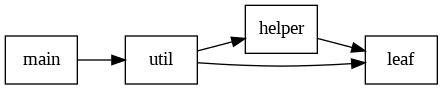

In [6]:
import subprocess, textwrap, pathlib

pathlib.Path("callgraph.dot").write_text(dot)
subprocess.run(["dot", "-Tpng", "callgraph.dot", "-o", "callgraph.png"], check=True)

from PIL import Image
Image.open("callgraph.png")
